In [1]:
%tensorflow_version 1.13.x
import tensorflow as tf
import os
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [3]:
# !pip install seqeval
# !pip install git+https://www.github.com/keras-team/keras-contrib.git
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import re
import os

import tensorflow as tf
import keras

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

from prettytable import PrettyTable


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
data = pd.read_csv("./gdrive/My Drive/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.head()

Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O

In [6]:
data.groupby('Tag').size().reset_index(name='counts')
# data.groupby(['Tag']).sum().plot(kind='pie', y='counts')


Tag  counts
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908

In [7]:
# data.groupby(['Tag']).sum().plot(kind='pie')

In [8]:
data.shape

(1048575, 4)

In [9]:
# data=data.iloc[:100023,:]

In [10]:
data.shape

(1048575, 4)

In [11]:
from tqdm import tqdm
import re,string,unicodedata
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data.groupby("Sentence #").apply(to_tuples).tolist()

print(sentences[0])

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [13]:
words = [[word[0] for word in sentence] for sentence in sentences]
words[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [14]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Number of unique tags in dataset:", n_tags)

Number of unique tags in dataset: 17


In [15]:
tag_to_idx = {t: i for i, t in enumerate(tags)}
# word_to_idx
tag_to_idx

{'B-art': 11,
 'B-eve': 8,
 'B-geo': 5,
 'B-gpe': 16,
 'B-nat': 2,
 'B-org': 10,
 'B-per': 0,
 'B-tim': 9,
 'I-art': 4,
 'I-eve': 7,
 'I-geo': 14,
 'I-gpe': 3,
 'I-nat': 6,
 'I-org': 1,
 'I-per': 12,
 'I-tim': 15,
 'O': 13}

In [16]:
y=data['Tag']
#print(y)

In [17]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
token = Tokenizer()


In [19]:
token.fit_on_texts(words)

In [20]:
word_index=token.word_index
len(word_index)

31799

In [21]:
vocab_size=len(token.word_index)+1
vocab_size

31800

In [22]:
print(token.index_word)

{1: 'the', 2: '.', 3: ',', 4: 'in', 5: 'of', 6: 'to', 7: 'a', 8: 'and', 9: "'s", 10: 'for', 11: 'has', 12: 'on', 13: 'is', 14: 'that', 15: 'have', 16: 'with', 17: 'said', 18: 'was', 19: 'at', 20: 'says', 21: 'from', 22: 'by', 23: 'he', 24: 'us', 25: 'an', 26: 'as', 27: 'say', 28: 'it', 29: 'are', 30: '"', 31: 'were', 32: 'his', 33: 'will', 34: 'president', 35: 'officials', 36: 'government', 37: 'mr.', 38: 'been', 39: 'killed', 40: 'two', 41: 'people', 42: 'after', 43: 'not', 44: 'its', 45: 'be', 46: 'but', 47: 'they', 48: 'more', 49: 'also', 50: 'new', 51: 'united', 52: 'military', 53: 'who', 54: 'last', 55: 'country', 56: 'than', 57: 'minister', 58: 'police', 59: 'their', 60: 'iraq', 61: 'one', 62: 'which', 63: 'security', 64: 'this', 65: 'about', 66: 'year', 67: 'other', 68: 'had', 69: 'states', 70: 'least', 71: 'tuesday', 72: 'since', 73: 'forces', 74: 'world', 75: 'thursday', 76: 'week', 77: 'group', 78: 'iran', 79: 'over', 80: 'state', 81: 'friday', 82: 'monday', 83: 'wednesday', 

In [23]:
encoded_text=token.texts_to_sequences(words)

In [24]:
len(encoded_text)

47959

In [25]:
maxlen=200
x=pad_sequences(encoded_text,maxlen=maxlen,padding="post")
x[0]

array([ 253,    5,  965,   15, 1793,  237,  467,    6,  522,    1,  128,
          4,   60,    8,  570,    1,  831,    5,  185,   89,   21,   14,
         55,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [26]:
x.shape

(47959, 200)

In [27]:
y = [[tag_to_idx[w[2]] for w in s] for s in sentences]
# Padding tags to match length of sentence
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag_to_idx["O"])
# Make y categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [28]:
# y=np.array(y)
# y.shape

In [29]:
glove_vectors=dict()

In [30]:
%%time

file=open('./gdrive/My Drive/glove.twitter.27B.100d.txt',encoding='utf-8')

for line in file:
  values=line.split()
  word=values[0]
  vectors=np.asarray(values[1:])
  glove_vectors[word]=vectors
file.close()

CPU times: user 33.1 s, sys: 8.32 s, total: 41.4 s
Wall time: 42.2 s


In [31]:
len(glove_vectors.keys())

1193514

In [32]:
glove_vectors.get("you").shape

(100,)

In [33]:
word_vector_matrix=np.zeros((vocab_size,100))
word_vector_matrix.shape

(31800, 100)

In [34]:
for word,index in token.word_index.items():
  vector=glove_vectors.get(word)
  if vector is not None:
    word_vector_matrix[index]=vector
  else:
    pass
    # print(word)

In [35]:
print(word_vector_matrix.shape)

(31800, 100)


In [36]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2,)

In [37]:
# x_train[0]

In [38]:
word_vector_matrix[2]

array([ 0.18205  , -0.048483 ,  0.23966  ,  0.32099  , -0.27002  ,
        0.70431  , -0.21257  ,  0.235    ,  0.090142 ,  0.82141  ,
        0.37843  , -0.56382  , -2.4447   ,  0.16827  ,  0.24685  ,
        0.28649  ,  0.062312 ,  0.067508 , -0.58459  , -0.45414  ,
       -0.22158  ,  0.17423  , -0.35558  ,  0.14485  ,  0.49089  ,
       -1.7426   , -0.54306  , -0.51937  ,  0.94795  , -0.41739  ,
       -0.55238  , -0.057398 , -0.52663  ,  0.62976  ,  0.097275 ,
        0.20637  ,  0.46261  ,  0.089462 ,  0.016019 , -0.53854  ,
       -1.2043   ,  0.080287 , -0.65351  ,  0.044617 ,  0.79527  ,
        0.044508 ,  0.53367  ,  0.27444  , -0.32461  , -0.053683 ,
       -0.79304  ,  0.11     ,  0.39762  , -0.044155 ,  0.21701  ,
        0.27977  , -0.25773  ,  0.25085  ,  0.39711  ,  0.32318  ,
        0.10245  , -0.030471 ,  0.34113  ,  0.17971  ,  0.44436  ,
        0.054915 ,  0.22461  , -0.80843  , -0.11052  ,  0.42366  ,
        0.61091  ,  0.55024  ,  0.21958  , -0.3029   ,  0.1454

In [39]:
print(x_train.shape)
print(x_test.shape)
y_train=np.array(y_train)
y_test=np.array(y_test)
print(y_train.shape)
print(y_test.shape)

(38367, 200)
(9592, 200)
(38367, 200, 17)
(9592, 200, 17)


In [40]:
#y_train.shape

In [41]:
input = Input(shape=(maxlen,))
model = Embedding(vocab_size,
                            100,
                            weights=[word_vector_matrix],
                            input_length=maxlen,
                            trainable=False)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(n_tags, learn_mode = 'join', test_mode = 'viterbi') 
out = crf(model)  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [42]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install plot_keras_history
# !pip install git+https://www.github.com/keras-team/keras-contrib.git
from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

from keras import layers
from keras import optimizers

from keras.models import Model
from keras.models import Input

from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-v90hc_8u
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-v90hc_8u


In [43]:
from keras import optimizers
# import tensorflow as tf 
from keras_contrib import losses
model = Model(input, out)
loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
#opt = optimizers.Adam(lr=0.001)
model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_viterbi_accuracy])
model.compile(optimizer='rmsprop', loss=loss, metrics=[acc_metric])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          3180000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 100)          60400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 200, 17)           1190      
Total params: 3,246,640
Trainable params: 66,640
Non-trainable params: 3,180,000
_________________________________________________________________


In [46]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

#history_glove = model.fit(x_train, y_train, batch_size=1024, epochs=6, validation_data=(x_test, y_test), verbose=1)
history_glove = model.fit(x_train, y_train, batch_size=64, epochs=6, validation_split=0.2, verbose=1)

Train on 30693 samples, validate on 7674 samples
Epoch 1/6
30693/30693 [==============================] - 250s 8ms/step - loss: 0.0789 - crf_accuracy: 0.9781 - val_loss: 0.0181 - val_crf_accuracy: 0.9936
Epoch 2/6
30693/30693 [==============================] - 244s 8ms/step - loss: 0.0137 - crf_accuracy: 0.9942 - val_loss: 0.0101 - val_crf_accuracy: 0.9946
Epoch 3/6
30693/30693 [==============================] - 245s 8ms/step - loss: 0.0075 - crf_accuracy: 0.9949 - val_loss: 0.0054 - val_crf_accuracy: 0.9950
Epoch 4/6
30693/30693 [==============================] - 244s 8ms/step - loss: 0.0032 - crf_accuracy: 0.9953 - val_loss: 0.0020 - val_crf_accuracy: 0.9952
Epoch 5/6
30693/30693 [==============================] - 244s 8ms/step - loss: -4.1147e-04 - crf_accuracy: 0.9955 - val_loss: -0.0011 - val_crf_accuracy: 0.9953
Epoch 6/6
30693/30693 [==============================] - 244s 8ms/step - loss: -0.0037 - crf_accuracy: 0.9957 - val_loss: -0.0042 - val_crf_accuracy: 0.9953


In [47]:
hist = pd.DataFrame(history_glove.history)
hist

val_loss  val_crf_accuracy      loss  crf_accuracy
0  0.018088          0.993588  0.078886      0.978119
1  0.010133          0.994629  0.013699      0.994189
2  0.005414          0.995026  0.007541      0.994881
3  0.001999          0.995187  0.003167      0.995267
4 -0.001141          0.995337 -0.000411      0.995460
5 -0.004181          0.995323 -0.003652      0.995687

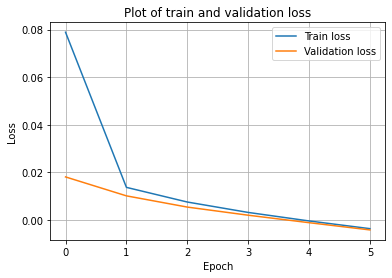

In [48]:
plt.plot(hist["loss"], label="Train loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Plot of train and validation loss")
plt.grid()
plt.show()

In [ ]:
# Predict output for test data
test_pred = model.predict(x_test, verbose=1)
# Index as key and tag as value
idx_to_tag = {i: w for w, i in tag_to_idx.items()}
# Function to convert indexed tags to corresponding actual tags
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx_to_tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

accuracy_score(test_labels, pred_labels)

9592/9592 [==============================] - 31s 3ms/step
Accuracy:  0.9953570683903252


In [49]:
from future.utils import iteritems
tags = list(set(data["Tag"].values))
number_tags = len(tags)

tag2idx = {t: i+1 for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in iteritems(tag2idx)}

In [51]:
#Evaluating the model
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(x_test))  
print(classification_report(np.argmax(y_test, 2).ravel(), 
                            np.argmax(y_pred, axis=2).ravel(),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

       B-per       0.63      0.66      0.65      3394
       I-org       0.60      0.07      0.13        40
       B-nat       0.86      0.55      0.67        33
       I-gpe       0.00      0.00      0.00        84
       I-art       0.85      0.86      0.86      7558
       B-geo       0.00      0.00      0.00        13
       I-nat       0.33      0.03      0.06        65
       I-eve       0.75      0.21      0.33        70
       B-eve       0.86      0.87      0.86      4077
       B-tim       0.73      0.61      0.66      4151
       B-org       0.00      0.00      0.00        94
       B-art       0.82      0.93      0.87      3406
       I-per       1.00      1.00      1.00   1886160
           O       0.81      0.69      0.75      1462
       I-geo       0.76      0.76      0.76      1251
       I-tim       0.96      0.92      0.94      3142
       B-gpe       0.00      0.00      0.00         0

   micro avg       1.00   